In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math
from monotone_woe import Binning

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SVMSMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
application = pd.read_csv("D:/Dataset/Credit Risk/application_record.csv")
credit = pd.read_csv("D:/Dataset/Credit Risk/credit_record.csv")

In [3]:
display(application.head())
print(application.shape)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


(438557, 18)


In [4]:
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
table1 = pd.DataFrame(credit.groupby('ID')['MONTHS_BALANCE'].agg(min))
table1['month_acc_closed'] = credit.groupby('ID')['MONTHS_BALANCE'].max()
table1.reset_index(inplace=True)
table1.columns = ['ID','month_acc_opened','month_acc_closed'] 
table1['window'] = table1['month_acc_closed'] - table1['month_acc_opened']

application1 = pd.merge(application, table1, on = 'ID', how = 'left')
application1

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,month_acc_opened,month_acc_closed,window
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-15.0,0.0,15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-14.0,0.0,14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,-29.0,0.0,29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-4.0,0.0,4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,-22.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,...,365243,1,0,0,0,NaN,1.0,NaN,NaN,NaN
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,-3007,1,0,0,0,Laborers,1.0,NaN,NaN,NaN
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,...,-372,1,1,0,0,Sales staff,1.0,NaN,NaN,NaN
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,365243,1,0,0,0,NaN,2.0,NaN,NaN,NaN


### Creating target variable

In [6]:
# If past due is greater than 60, then the customer is bad
credit['target'] = credit['STATUS'].apply(lambda x: 1 if x in ['2','3','4','5'] else 0)
application2 = pd.merge(application1, credit[['ID','target']], on = 'ID', how = 'inner')
application2 = application2[application2['window'] > 21] # If window is less than 21, then drop
application2

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,month_acc_opened,month_acc_closed,window,target
31,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,-29.0,0.0,29.0,0
32,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,-29.0,0.0,29.0,0
33,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,-29.0,0.0,29.0,0
34,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,-29.0,0.0,29.0,0
35,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,-29.0,0.0,29.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777686,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,0,1,1,Medicine staff,2.0,-32.0,0.0,32.0,0
777687,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,0,1,1,Medicine staff,2.0,-32.0,0.0,32.0,0
777688,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,0,1,1,Medicine staff,2.0,-32.0,0.0,32.0,0
777689,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,0,1,1,Medicine staff,2.0,-32.0,0.0,32.0,0


In [7]:
print(application2.isna().sum())

application2.dropna(inplace = True)

application2['target'] = application2['target'].astype('int')

print(application2.shape)

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        169577
CNT_FAM_MEMBERS             0
month_acc_opened            0
month_acc_closed            0
window                      0
target                      0
dtype: int64
(379795, 22)


In [8]:
num_col = ['ID','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','month_acc_opened']
cat_col = [col for col in application2.columns if col not in num_col][:-1]
num_col = num_col[1:]

In [9]:
def calc_woe_iv(column):
    woe = pd.crosstab(application2[column], application2['target'])
    woe.columns = ['Good','Bad']

    woe['% of Good'] = woe['Good']/application2['target'].value_counts()[0]
    woe['% of Bad'] = woe['Bad']/application2['target'].value_counts()[1]

    woe['WOE'] = woe['% of Good']/woe['% of Bad']

    woe['WOE'] = woe['WOE'].apply(lambda x: math.log(x))

    woe = woe.replace({'WOE': {np.inf: 0, -np.inf: 0}})

    woe['IV'] = (woe['% of Good']-woe['% of Bad']) * woe['WOE']
    display(woe)
    print(f"Information Value of {column} = {woe['IV'].sum()}")

    return woe['IV'].sum(), woe['WOE'].to_dict()

def check_importance(x):

    if x<0.02:
        return 'Useless'
    elif x>=0.02 and x<0.1:
        return 'Weak'
    elif x>=0.1 and x<0.3:
        return 'Medium'
    elif x>=0.3 and x<0.5:
        return 'Stong'
    elif x>0.5:
        return 'Suspicious'

def calc_woe_iv_num(column, bins, qcut, display_woe):
    epsilon= 0.5

    temp = application2[[column, 'target']]
    if qcut == True:
        temp['Bins'] = pd.qcut(temp[column], q = bins, labels = [i for i in range(1,bins+1)])
    else:
        temp['Bins'] = pd.cut(temp[column], bins = bins, labels = [i for i in range(1,bins+1)])

    woe = pd.crosstab(temp['Bins'], temp['target'])
    woe.columns = ['Good','Bad']

    woe['% of Good'] = (woe['Good'] + epsilon)/(temp['target'].value_counts()[0] + 2*epsilon)
    woe['% of Bad'] = (woe['Bad'] + epsilon)/(temp['target'].value_counts()[1] + 2*epsilon)

    woe['WOE'] = woe['% of Good']/woe['% of Bad']

    woe['WOE'] = woe['WOE'].apply(lambda x: math.log(x))

    woe = woe.replace({'WOE': {np.inf: 0, -np.inf: 0}})

    woe['IV'] = (woe['% of Good']-woe['% of Bad']) * woe['WOE']
    sum_iv = woe['IV'].sum()

    if display_woe:
        display(woe)
    print(f"Information Value of Bins = {sum_iv}")

    plt.bar(x = [i for i in range(1,bins+1)], height = woe['WOE'])
    plt.axhline(0, linewidth = 0.7, color = 'black')
    plt.xlabel('Bins')
    plt.ylabel('WOE')
    plt.show()

    return sum_iv

In [10]:
num_col

['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'month_acc_opened']

Information Value of Bins = 0.3283581435149553


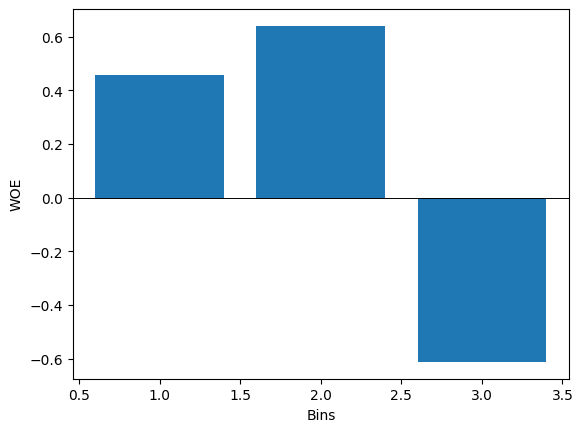

np.float64(0.3283581435149553)

In [37]:
calc_woe_iv_num('DAYS_EMPLOYED',3, True, False)

,Good,Bad,% of Good,% of Bad,WOE,IV
CODE_GENDER,,,,,,
F,234954,786,0.621267,0.488199,0.241039,0.032075
M,143231,824,0.378733,0.511801,-0.301106,0.040068


Information Value of CODE_GENDER = 0.07214245254133721


,Good,Bad,% of Good,% of Bad,WOE,IV
FLAG_OWN_CAR,,,,,,
N,213093,861,0.563462,0.534783,0.05224,0.001498
Y,165092,749,0.436538,0.465217,-0.06363,0.001825


Information Value of FLAG_OWN_CAR = 0.003323126803765921


,Good,Bad,% of Good,% of Bad,WOE,IV
FLAG_OWN_REALTY,,,,,,
N,137841,488,0.36448,0.303106,0.184391,0.011317
Y,240344,1122,0.63552,0.696894,-0.092191,0.005658


Information Value of FLAG_OWN_REALTY = 0.016975171215952718


,Good,Bad,% of Good,% of Bad,WOE,IV
CNT_CHILDREN,,,,,,
0,243022,971,0.642601,0.603106,0.063431,0.002505
1,87410,469,0.231130,0.291304,-0.231387,0.013924
2,42181,140,0.111535,0.086957,0.248933,0.006118
3,4659,25,0.012319,0.015528,-0.231469,0.000743
4,631,5,0.001668,0.003106,-0.621281,0.000893
5,133,0,0.000352,0.000000,0.000000,0.000000
7,46,0,0.000122,0.000000,0.000000,0.000000
14,103,0,0.000272,0.000000,0.000000,0.000000


Information Value of CNT_CHILDREN = 0.024182770621507713


,Good,Bad,% of Good,% of Bad,WOE,IV
NAME_INCOME_TYPE,,,,,,
Commercial associate,106767,647,0.282314,0.401863,-0.353091,0.042212
Pensioner,220,18,0.000582,0.011180,-2.955894,0.031328
State servant,37657,84,0.099573,0.052174,0.646308,0.030634
Student,294,0,0.000777,0.000000,0.000000,0.000000
Working,233247,861,0.616754,0.534783,0.142609,0.011690


Information Value of NAME_INCOME_TYPE = 0.11586375268961402


,Good,Bad,% of Good,% of Bad,WOE,IV
NAME_EDUCATION_TYPE,,,,,,
Academic degree,389,0,0.001029,0.000000,0.000000,0.000000
Higher education,108357,523,0.286519,0.324845,-0.125544,0.004812
Incomplete higher,13850,73,0.036622,0.045342,-0.213568,0.001862
Lower secondary,3506,35,0.009271,0.021739,-0.852266,0.010627
Secondary / secondary special,252083,979,0.666560,0.608075,0.091833,0.005371


Information Value of NAME_EDUCATION_TYPE = 0.0226711980521487


,Good,Bad,% of Good,% of Bad,WOE,IV
NAME_FAMILY_STATUS,,,,,,
Civil marriage,30110,49,0.079617,0.030435,0.961643,0.047296
Married,274861,1154,0.726790,0.716770,0.013882,0.000139
Separated,22056,50,0.058321,0.031056,0.630168,0.017181
Single / not married,42705,293,0.112921,0.181988,-0.477251,0.032962
Widow,8453,64,0.022351,0.039752,-0.575756,0.010018


Information Value of NAME_FAMILY_STATUS = 0.10759659974937281


,Good,Bad,% of Good,% of Bad,WOE,IV
NAME_HOUSING_TYPE,,,,,,
Co-op apartment,2600,21,0.006875,0.013043,-0.640405,0.003950
House / apartment,334498,1402,0.884482,0.870807,0.015582,0.000213
Municipal apartment,12850,77,0.033978,0.047826,-0.341856,0.004734
Office apartment,2875,22,0.007602,0.013665,-0.586384,0.003555
Rented apartment,5557,6,0.014694,0.003727,1.371905,0.015046
With parents,19805,82,0.052369,0.050932,0.027821,0.000040


Information Value of NAME_HOUSING_TYPE = 0.02753828634186265


,Good,Bad,% of Good,% of Bad,WOE,IV
FLAG_MOBIL,,,,,,
1,378185,1610,1.0,1.0,0.0,0.0


Information Value of FLAG_MOBIL = 0.0


,Good,Bad,% of Good,% of Bad,WOE,IV
FLAG_WORK_PHONE,,,,,,
0,270438,1040,0.715094,0.645963,0.101673,0.007029
1,107747,570,0.284906,0.354037,-0.217245,0.015018


Information Value of FLAG_WORK_PHONE = 0.022047308530818533


,Good,Bad,% of Good,% of Bad,WOE,IV
FLAG_PHONE,,,,,,
0,264002,991,0.698076,0.615528,0.125848,0.010389
1,114183,619,0.301924,0.384472,-0.241697,0.019952


Information Value of FLAG_PHONE = 0.03034024666388935


,Good,Bad,% of Good,% of Bad,WOE,IV
FLAG_EMAIL,,,,,,
0,340569,1506,0.900535,0.935404,-0.037989,0.001325
1,37616,104,0.099465,0.064596,0.431645,0.015051


Information Value of FLAG_EMAIL = 0.016375301164099142


,Good,Bad,% of Good,% of Bad,WOE,IV
OCCUPATION_TYPE,,,,,,
Accountants,18859,70,0.049867,0.043478,0.137101,0.000876
Cleaning staff,7827,11,0.020696,0.006832,1.108290,0.015365
Cooking staff,9278,49,0.024533,0.030435,-0.215568,0.001272
Core staff,53860,186,0.142417,0.115528,0.209247,0.005626
Drivers,34654,173,0.091632,0.107453,-0.159272,0.002520
HR staff,1109,1,0.002932,0.000621,1.552065,0.003587
High skill tech staff,23332,121,0.061695,0.075155,-0.197359,0.002657
IT staff,986,0,0.002607,0.000000,0.000000,0.000000
Laborers,92276,383,0.243997,0.237888,0.025355,0.000155


Information Value of OCCUPATION_TYPE = 0.2575515728390541


,Good,Bad,% of Good,% of Bad,WOE,IV
CNT_FAM_MEMBERS,,,,,,
1.0,56833,259,0.150278,0.160870,-0.068105,0.000721
2.0,200240,803,0.529476,0.498758,0.059768,0.001836
3.0,75558,384,0.199791,0.238509,-0.177136,0.006858
4.0,39982,134,0.105721,0.083230,0.239196,0.005380
5.0,4689,25,0.012399,0.015528,-0.225051,0.000704
6.0,601,5,0.001589,0.003106,-0.669992,0.001016
7.0,133,0,0.000352,0.000000,0.000000,0.000000
9.0,46,0,0.000122,0.000000,0.000000,0.000000
15.0,103,0,0.000272,0.000000,0.000000,0.000000


Information Value of CNT_FAM_MEMBERS = 0.016515650917123814


,Good,Bad,% of Good,% of Bad,WOE,IV
month_acc_closed,,,,,,
-39.0,22,0,0.000058,0.000000,0.000000,0.000000e+00
-38.0,112,0,0.000296,0.000000,0.000000,0.000000e+00
-37.0,233,0,0.000616,0.000000,0.000000,0.000000e+00
-36.0,331,0,0.000875,0.000000,0.000000,0.000000e+00
-35.0,317,0,0.000838,0.000000,0.000000,0.000000e+00
-34.0,197,0,0.000521,0.000000,0.000000,0.000000e+00
-33.0,313,0,0.000828,0.000000,0.000000,0.000000e+00
-32.0,322,0,0.000851,0.000000,0.000000,0.000000e+00
-31.0,635,0,0.001679,0.000000,0.000000,0.000000e+00


Information Value of month_acc_closed = 0.16976201112227526


,Good,Bad,% of Good,% of Bad,WOE,IV
window,,,,,,
21.0,10580,46,0.027976,0.028571,-0.021070,0.000013
22.0,10345,28,0.027354,0.017391,0.452905,0.004512
23.0,11819,13,0.031252,0.008075,1.353365,0.031367
24.0,12438,12,0.032889,0.007453,1.484456,0.037757
25.0,11917,43,0.031511,0.026708,0.165372,0.000794
26.0,10854,27,0.028700,0.016770,0.537303,0.006410
27.0,11033,27,0.029174,0.016770,0.553660,0.006867
28.0,11876,14,0.031403,0.008696,1.284068,0.029157
29.0,11228,22,0.029689,0.013665,0.775974,0.012435


Information Value of window = 0.6096637380258216


,Good,Bad,% of Good,% of Bad,WOE,IV
Bins,,,,,,
1,129027,605,0.341175,0.375854,-0.096805,0.003357
2,153752,628,0.406553,0.390130,0.041232,0.000677
3,95406,377,0.252274,0.234327,0.073800,0.001325


Information Value of Bins = 0.005358733494024484


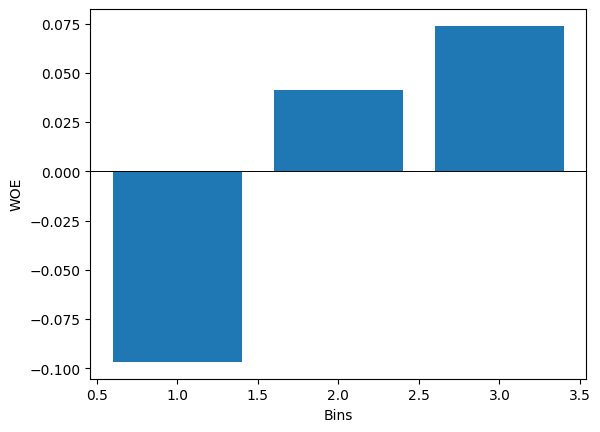

In [14]:
d = {}

cat_woe_map = {}
num_woe_map = {}

for col in cat_col:
    iv, feat_map = calc_woe_iv(col)
    cat_woe_map[col] = feat_map
    d[col] = iv

d['AMT_INCOME_TOTAL'] = calc_woe_iv_num('AMT_INCOME_TOTAL',3,True, True)

In [15]:
IV_table = pd.DataFrame(d.keys(),columns=['Column Name'])
IV_table['IV'] = d.values()
IV_table['importance'] = IV_table['IV'].apply(check_importance)
IV_table.sort_values(by = 'IV',ascending=False)

,Column Name,IV,importance
15,window,0.609664,Suspicious
12,OCCUPATION_TYPE,0.257552,Medium
14,month_acc_closed,0.169762,Medium
4,NAME_INCOME_TYPE,0.115864,Medium
6,NAME_FAMILY_STATUS,0.107597,Medium
0,CODE_GENDER,0.072142,Weak
10,FLAG_PHONE,0.030340,Weak
7,NAME_HOUSING_TYPE,0.027538,Weak
3,CNT_CHILDREN,0.024183,Weak
5,NAME_EDUCATION_TYPE,0.022671,Weak


## Preprocessing Data

In [16]:
df = application2.copy()

df.drop(['ID','window','month_acc_closed', 'month_acc_opened'],axis = 1,inplace = True)

df['CODE_GENDER'] = df['CODE_GENDER'].apply(lambda x: 1 if x == 'M' else 0)
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].apply(lambda x: 1 if x == 'Y' else 0)
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].apply(lambda x: 1 if x == 'Y' else 0)

df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].apply(lambda x: cat_woe_map['NAME_INCOME_TYPE'][x])
df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].apply(lambda x: cat_woe_map['NAME_EDUCATION_TYPE'][x])
df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].apply(lambda x: cat_woe_map['NAME_FAMILY_STATUS'][x])
df['NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].apply(lambda x: cat_woe_map['NAME_HOUSING_TYPE'][x])
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].apply(lambda x: cat_woe_map['OCCUPATION_TYPE'][x])
df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].apply(lambda x: cat_woe_map['CNT_FAM_MEMBERS'][x])
df['CNT_CHILDREN'] = df['CNT_CHILDREN'].apply(lambda x: cat_woe_map['CNT_CHILDREN'][x])

df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target
31,1,1,1,0.063431,112500.0,0.142609,0.091833,0.013882,0.015582,-21474,-1134,1,0,0,0,-1.48291,0.059768,0
32,1,1,1,0.063431,112500.0,0.142609,0.091833,0.013882,0.015582,-21474,-1134,1,0,0,0,-1.48291,0.059768,0
33,1,1,1,0.063431,112500.0,0.142609,0.091833,0.013882,0.015582,-21474,-1134,1,0,0,0,-1.48291,0.059768,0
34,1,1,1,0.063431,112500.0,0.142609,0.091833,0.013882,0.015582,-21474,-1134,1,0,0,0,-1.48291,0.059768,0
35,1,1,1,0.063431,112500.0,0.142609,0.091833,0.013882,0.015582,-21474,-1134,1,0,0,0,-1.48291,0.059768,0


## Oversampling the dataset

In [29]:
X = df.drop(['target'],axis = 1)
y = df['target'] 

In [30]:
svm_smote = SVMSMOTE()
X_res, y_res = svm_smote.fit_resample(X, y)

In [31]:
IV_table.sort_values(by = 'IV', ascending= False)

,Column Name,IV,importance
15,window,0.609664,Suspicious
12,OCCUPATION_TYPE,0.257552,Medium
14,month_acc_closed,0.169762,Medium
4,NAME_INCOME_TYPE,0.115864,Medium
6,NAME_FAMILY_STATUS,0.107597,Medium
0,CODE_GENDER,0.072142,Weak
10,FLAG_PHONE,0.030340,Weak
7,NAME_HOUSING_TYPE,0.027538,Weak
3,CNT_CHILDREN,0.024183,Weak
5,NAME_EDUCATION_TYPE,0.022671,Weak


## Training the Model

In [32]:
extra_drop = ['FLAG_MOBIL']
new_X_res = X_res.drop(extra_drop,axis = 1)

X_train, X_test, y_train, y_test = train_test_split(new_X_res,y_res,test_size=0.25,stratify=y_res,random_state=42)

0.7862772507963481
0.7856821775528444


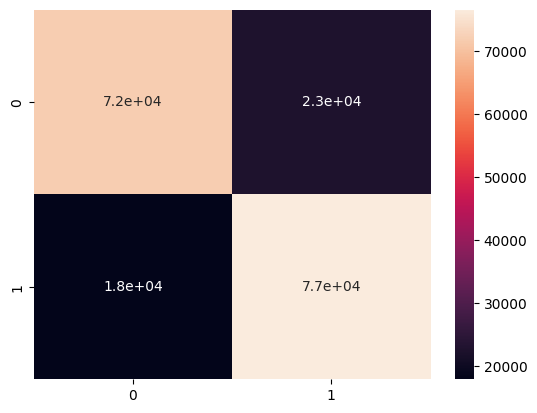

In [33]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

print(lr.score(X_train,y_train))
print(lr.score(X_test, y_test))

y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)
plt.show()

## Best Model

0.7862772507963481
0.7856821775528444


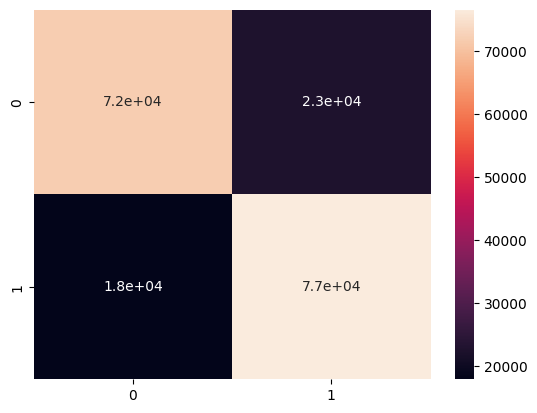

In [34]:
extra_drop = ['FLAG_MOBIL']

lr = LogisticRegression()
lr.fit(X_train, y_train)

print(lr.score(X_train,y_train))
print(lr.score(X_test, y_test))

y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)
plt.show()

## Base Model

0.7637679652092364
0.7605834166256815


<Axes: >

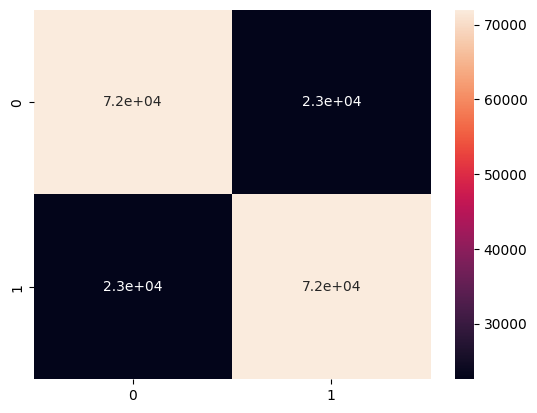

In [190]:
base_model = LogisticRegression()
base_model.fit(X_train, y_train)

print(base_model.score(X_train,y_train))
print(base_model.score(X_test, y_test))

y_pred = base_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)

0.9963499619303354
0.9963499831448266


<Axes: >

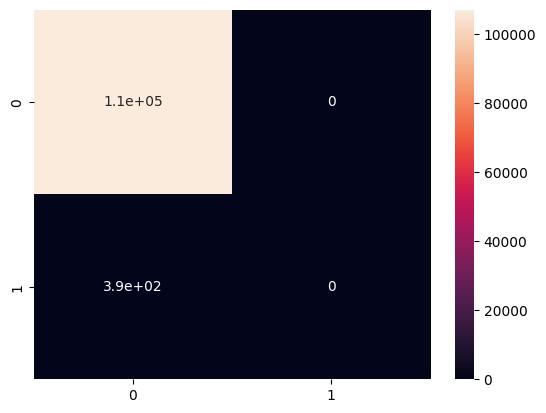

In [57]:
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

print(svm.score(X_train,y_train))
print(svm.score(X_val, y_val))

y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)